# Bayesian system identification

## Algorithms
DMD, SINDy, Linear and Unscented Kalman filters

## Linear pendulum

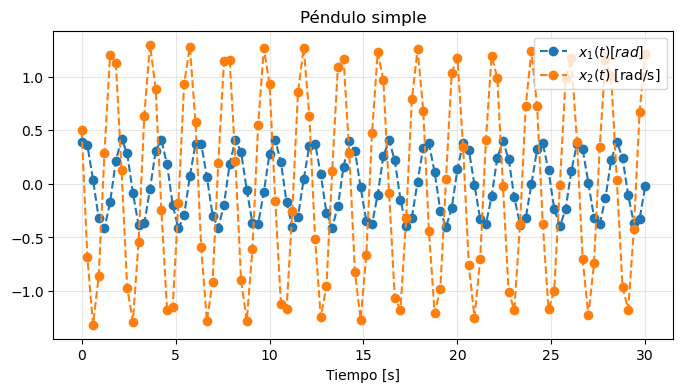

In [77]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

g = 9.81      
L = 1.0       
m = 1.0      
c = 0.005       
def pendulo_amortiguado(t, y):
    theta, omega = y
    dtheta_dt = omega
    domega_dt = - (c / (m * L**2)) * omega - (g / L) * np.sin(theta)
    return [dtheta_dt, domega_dt]
theta0 = np.pi / 8   
omega0 = 0.5
y0 = [theta0, omega0]
t_span = (0, 30)     
t_eval = np.linspace(*t_span, 100)
sol_LP = solve_ivp(pendulo_amortiguado, t_span, y0, t_eval=t_eval)
plt.figure(figsize=(8,4))
plt.plot(sol_LP.t, sol_LP.y[0], 'o--',label=r'$x_1(t) [rad]$')
plt.plot(sol_LP.t, sol_LP.y[1], 'o--',label=r'$x_2(t)$ [rad/s]')
plt.xlabel('Tiempo [s]')
#plt.ylabel('Ángulo [rad]')
plt.title('Péndulo simple')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()


In [ ]:
def loss_function_2(theta, t_data, y_data, f, x0):
    """
    Calcula la pérdida sum_{i} || y_i - x(t_i; theta) ||^2

    Parámetros:
    ----------
    theta : array_like
        Parámetros del modelo dinámico.
    t_data : array_like
        Tiempos de observación (ordenados crecientes).
    y_data : array_like
        Observaciones (n x d)
    f : callable
        f(t, x, theta) -> dx/dt
    x0 : array_like
        Condición inicial x(t0)
    """
    # Resolver la EDO para este theta
    sol = solve_ivp(lambda t, x: f(t, x, theta),
                    (t_data[0], t_data[-1]),
                    x0,
                    t_eval=t_data,
                    method='RK45')

    # Trayectoria simulada
    x_model = sol.y.T  # shape (n, d)

    # Calcular pérdida cuadrática
    residuals = y_data - x_model
    return np.sum(residuals**2)

In [ ]:
import numpy as np
from scipy import linalg

def _log_gaussian_density(y, mu, S):
    """
    Devuelve log N(y | mu, S) de forma numéricamente estable.
    S: covariance matrix (m x m)
    """
    # usar factorización de Cholesky cuando sea posible
    try:
        c, lower = linalg.cho_factor(S, check_finite=False)
        diff = y - mu
        sol = linalg.cho_solve((c, lower), diff, check_finite=False)
        logdet = 2.0 * np.sum(np.log(np.diag(c)))
        quad = float(diff.T @ sol)
        m = y.shape[0]
        return -0.5 * (m * np.log(2 * np.pi) + logdet + quad)
    except np.linalg.LinAlgError:
        # fallback: slogdet + solve (menos estable pero funcional)
        sign, logdet = np.linalg.slogdet(S)
        if sign <= 0:
            # matriz no positiva definida; penalizamos fuertemente
            return -1e300
        sol = np.linalg.solve(S, (y - mu))
        quad = float((y - mu).T @ sol)
        m = y.shape[0]
        return -0.5 * (m * np.log(2 * np.pi) + logdet + quad)


def evaluate_posterior_over_thetas(theta,
                                  Y,
                                  prior_logpdf,
                                  A_fn,
                                  H_fn,
                                  Sigma_fn,
                                  Gamma_fn,
                                  m0,
                                  P0):
    """
    Evaluate p(theta | Y_n) for theta.

    Inputs:
    - thetas: array-like shape (N_theta, p) o (p,) si un solo theta
    - Y: array shape (n_timesteps, m) observaciones y_k
    - prior_logpdf: callable(theta_vector) -> log p(theta)
    - A_fn(theta) -> A matrix (d x d)
    - H_fn(theta) -> H matrix (m x d)
    - Sigma_fn(theta) -> process covariance Sigma (d x d)
    - Gamma_fn(theta) -> measurement covariance Gamma (m x m)
    - m0: initial mean (d,)
    - P0: initial covariance (d x d)

    Returns dict con arrays:
    - log_prior (N,)
    - log_likelihood (N,)
    - log_posterior (N,) = log_prior + log_likelihood
    - posterior_prob (N,) normalized to sum 1 (exp & normalize de log_posterior)
    """
    Y = np.asarray(Y)
    n, m = Y.shape


    log_prior = np.empty(1)
    log_like = np.empty(1)

    # prior
    lp = prior_logpdf(theta)
    log_prior = lp

    # initialize KF
    mk = m0.copy()
    Pk = P0.copy()
    logL = 0.0

    # sequential Kalman filter
    for k in range(n):
        # Predict
        A = np.atleast_2d(A_fn(theta))
        Sigma = np.atleast_2d(Sigma_fn(theta))

        m_minus = A @ mk
        P_minus = A @ Pk @ A.T + Sigma

        # Evidence
        H = np.atleast_2d(H_fn(theta))
        Gamma = np.atleast_2d(Gamma_fn(theta))

        mu_k = H @ m_minus #y_pred
        S_k = H @ P_minus @ H.T + Gamma #innovation covariance
        yk = Y[k] # innovation
        logp = _log_gaussian_density(yk, mu_k, S_k)
        logL += logp

        # Update
        # Kalman gain K = P_minus H^T S_k^{-1}
        try:
            c, lower = linalg.cho_factor(S_k, check_finite=False)
            S_inv_HT = linalg.cho_solve((c, lower), H, check_finite=False).T  # (d x m)
        except np.linalg.LinAlgError:
            S_inv = np.linalg.inv(S_k)
            S_inv_HT = (S_inv @ H).T
        K = P_minus @ H.T @ (np.linalg.inv(S_k) if False else S_inv_HT.T)
        innovation = (yk - mu_k)
        mk = m_minus + K @ innovation
        Pk = P_minus - K @ H @ P_minus
        Pk = (Pk + Pk.T) / 2.0

    log_like = logL

    log_post = log_prior + log_like
    return {
        'theta': theta,
        'log_prior': log_prior,
        'log_likelihood': log_like,
        'log_posterior': log_post,
        'prediction': (mk,Pk)
    }


# ---------------------------
# Ejemplo de uso (modelo simple)
# ---------------------------
if __name__ == "__main__":
    # Dimensiones
    d = 2   # estado
    m = 2   # observación

    # Modelo simple A, H independientes de theta para ilustrar:
    def A_fn(theta):
        # theta no usado en este ejemplo; A fijo
        return np.array([[1.0, 0.1],
                         [-0.98, 1.0]])

    def H_fn(theta):
        return np.eye(2)

    def Sigma_fn(theta):
        # vamos a usar theta[0] = process_variance
        s = float(theta[0])
        return s * np.eye(d)

    def Gamma_fn(theta):
        # theta[1] = measurement_variance
        g = float(theta[1])
        return g * np.eye(m)

    # Prior logpdf: ejemplo independiente (half-normal-like impropia),
    # aquí ponemos una prior simple: independ. log-normal (para positividad)
    def prior_logpdf(theta):
        # theta = [sigma_proc, sigma_meas], supongamos sigma>0
        if np.any(theta <= 0):
            return -1e300
        # log-normal with mean 0, std 1 in log-space:
        return -0.5 * np.sum((np.log(theta) / 1.0) ** 2) - np.sum(np.log(theta))

    # Generar datos sintéticos con theta_true
    theta_true = np.array([1e-2, 0.05])
    A_true = A_fn(theta_true)
    Sigma_true = Sigma_fn(theta_true)
    Gamma_true = Gamma_fn(theta_true)
    T = 50
    x = np.zeros((T, d))
    y = np.zeros((T, m))
    x0 = np.array([0.1, -0.5])
    x[0] = x0
    rng = np.random.default_rng(123)
    for k in range(1, T):
        x[k] = A_true @ x[k-1] + rng.multivariate_normal(np.zeros(d), Sigma_true)
    for k in range(T):
        y[k] = H_fn(theta_true) @ x[k] + rng.multivariate_normal(np.zeros(m), Gamma_true)

    # Iniciales del KF (incertidumbre grande)
    m0 = np.zeros(d)
    P0 = np.eye(d) * 1.0


    res = evaluate_posterior_over_thetas(np.array([0.015, 0.052]), y, prior_logpdf,
                                        A_fn, H_fn, Sigma_fn, Gamma_fn,
                                        m0, P0)

    # mostrar resultados resumidos
    for theta, lp, ll, lpost in zip(res['thetas'], res['log_prior'], res['log_likelihood'],
                                      res['log_posterior']):
        print(f"theta={theta}, logprior={lp:.3f}, loglike={ll:.3f}, logpost={lpost:.3f}")


theta=[0.015 0.052], logprior=-6.033, loglike=-13.785, logpost=-19.818


## Non linear pendulum

## Van der Pol

## Lorenz

## Reaction-diffusion